## **Comprehensive Libraries and Functions for Data Analysis and Machine Learning Tasks**
This collection of code imports necessary libraries for various data analysis and machine learning tasks, including clustering, feature selection, classification, scaling, visualization, and dimensionality reduction techniques.

In [ ]:
#Cell 1
import json
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from itertools import combinations
from sklearn.feature_selection import f_classif

#Cell 3
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest

#Cell 4
from collections import defaultdict

#Cell 5
!pip install deap

#Cell 6
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Cell 7
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#Cell 8
from sklearn.decomposition import FastICA

#Cell 9
from sklearn.decomposition import FactorAnalysis
import seaborn as sns

#Cell 10
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

#Cell 11
from sklearn.manifold import TSNE




In [ ]:
"""--------------------------------------------Implementation of Correlation based Feature Selection (CFS)-----------------------------------------------------------"""

# Load the data
df = pd.read_json('/content/stock_data_0.json')

# Handle missing values
df = df.dropna()

# Convert categorical columns to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# Separate features and target
X = df.drop('TYPE', axis=1)  # assuming 'TYPE' is the target
y = df['TYPE']

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
fit = selector.fit(X, y)

# Get the scores for each feature
scores = fit.scores_

# Create a DataFrame to view the features and their scores
features_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})

# Sort the DataFrame in descending order based on the scores
features_scores = features_scores.sort_values(by='Score', ascending=False)

print(features_scores)

# Select the top 3 features
top_features = features_scores.head(3)

print("\nTop 3 selected features:")
print(top_features)



         Feature     Score
1           COST  3.939864
7         P_HIGH  3.905738
6          P_LOW  3.897695
8     YEARLY_LOW  3.523001
9    YEARLY_HIGH  3.143633
3       WEAKNESS  3.083651
4  OPPORTUNITIES  1.607594
2       STRENGTH  1.273840
5        THREATS  1.209940
0           NAME  1.159735

Top 3 selected features:
  Feature     Score
1    COST  3.939864
7  P_HIGH  3.905738
6   P_LOW  3.897695


<ipython-input-43-899b532d25d3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category').cat.codes
<ipython-input-43-899b532d25d3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category').cat.codes
<ipython-input-43-899b532d25d3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
"""--------------------------------------------------------Implementation of Fast Correlation Based Feature Selection (FCBF)-------------------------------------------------------"""
# Load the data
df = pd.read_json('/content/stock_data_0.json')

# Handle missing values for numerical columns
numerical_cols = ['COST', 'P_LOW', 'P_HIGH', 'YEARLY_LOW', 'YEARLY_HIGH']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Define X and y based on numerical columns
X = df[numerical_cols].values
y = df['COST'].values

# Define FCBF function
def fcbf(X, y, threshold):
    # Calculate individual feature relevance
    feature_relevance = np.array([np.abs(np.corrcoef(X[:, i], y)[0, 1]) for i in range(X.shape[1])])

    # Initialize selected features list
    selected_features = []

    # Add features with relevance above threshold
    selected_features.append(np.argmax(feature_relevance))
    current_set = set(selected_features)

    # Iterate until no features meet the threshold
    while True:
        max_incremental_relevance = -np.inf
        best_feature = None

        # Calculate redundancy of each feature with respect to selected features
        for i in range(X.shape[1]):
            if i not in current_set:
                redundancy = np.mean([np.abs(np.corrcoef(X[:, i], X[:, j])[0, 1]) for j in selected_features])
                incremental_relevance = feature_relevance[i] - redundancy
                if incremental_relevance > max_incremental_relevance:
                    max_incremental_relevance = incremental_relevance
                    best_feature = i

        # If no feature meets the threshold, break the loop
        if max_incremental_relevance < threshold:
            break

        # Add best feature to selected features
        selected_features.append(best_feature)
        current_set = set(selected_features)

    return selected_features

# Apply FCBF to select features
threshold = 0.0005  # Set the threshold for feature selection
selected_feature_indices_fcbf = fcbf(X, y, threshold)

# Get selected feature names
selected_features_fcbf = [numerical_cols[i] for i in selected_feature_indices_fcbf]

print("Selected features based on Fast Correlation Based Feature Selection (FCBF):")
print(selected_features_fcbf)


Selected features based on Fast Correlation Based Feature Selection (FCBF):
['COST']


In [ ]:
"""--------------------------------------------------------Implementation of Fast Clustering based Feature Selection (FAST)-------------------------------------------------------"""


# Load the data
df = pd.read_json('/content/stock_data_0.json')

# Handle missing values for numerical columns
numerical_cols = ['COST', 'P_LOW', 'P_HIGH', 'YEARLY_LOW', 'YEARLY_HIGH']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Define X and y based on numerical columns
X = df[numerical_cols].values
y = df['COST'].values

# Define FAST function
def fast(X, y, threshold):
    # Initialize variables
    num_features = X.shape[1]
    selected_features = []

    # Perform K-Means clustering on the data
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    cluster_labels = kmeans.labels_

    # Calculate cluster centroids
    cluster_centers = kmeans.cluster_centers_

    # Calculate feature relevance
    feature_relevance = np.zeros(num_features)
    for i in range(num_features):
        feature_relevance[i] = np.abs(cluster_centers[0, i] - cluster_centers[1, i])

    # Select features based on threshold
    selected_features.append(np.argmax(feature_relevance))
    current_set = set(selected_features)

    # Iterate until no features meet the threshold
    while True:
        max_incremental_relevance = -np.inf
        best_feature = None

        # Calculate redundancy of each feature with respect to selected features
        for i in range(num_features):
            if i not in current_set:
                redundancy = 0
                for j in selected_features:
                    redundancy += np.abs(np.corrcoef(X[:, i], X[:, j])[0, 1])
                redundancy /= len(selected_features)
                incremental_relevance = feature_relevance[i] - redundancy
                if incremental_relevance > max_incremental_relevance:
                    max_incremental_relevance = incremental_relevance
                    best_feature = i

        # If no feature meets the threshold, break the loop
        if max_incremental_relevance < threshold:
            break

        # Add best feature to selected features
        selected_features.append(best_feature)
        current_set = set(selected_features)

    return selected_features

# Apply FAST to select features
threshold = 0.0005  # Set the threshold for feature selection
selected_feature_indices_fast = fast(X, y, threshold)

# Get selected feature names
selected_features_fast = [numerical_cols[i] for i in selected_feature_indices_fast]

print("Selected features based on Fast Clustering based Feature Selection (FAST):")
print(selected_features_fast[:3])



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected features based on Fast Clustering based Feature Selection (FAST):
['YEARLY_HIGH', 'P_HIGH', 'COST']


In [ ]:
"""---------------------------------------------------------------------Implementation of Relief algorithm--------------------------------------------------------------------------"""

def relief(X, y, m):
  """
  Performs Relief algorithm for feature selection.

  Args:
    X: A 2D numpy array representing the data.
    y: A 1D numpy array representing the target labels.
    m: The number of nearest neighbors to consider.

  Returns:
    A numpy array of feature weights.
  """

  num_samples, num_features = X.shape
  weights = np.zeros(num_features)

  for i in range(num_samples):
    # Select a random instance
    instance = X[i]
    label = y[i]

    # Find the nearest neighbors
    distances = np.sum((X - instance)**2, axis=1)
    neighbors = np.argsort(distances)[:m]

    # Find the nearest neighbors with different labels
    diff_labels = []
    for neighbor in neighbors:
      if y[neighbor] != label:
        diff_labels.append(neighbor)

    # Update the weights
    for j in range(num_features):
      weights[j] += np.mean(instance[j] - X[diff_labels, j]) - np.mean(instance[j] - X[neighbors, j])

  return weights

# Convert categorical columns to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# Separate features and target
X = df.drop('TYPE', axis=1)  # assuming 'TYPE' is the target
y = df['TYPE']

# Perform feature selection
weights = relief(X.values, y.values, 5)

# Sort the features by their weights
sorted_features = np.argsort(weights)[::-1]

# Print the top 3 features
print("Top 3 features based on Relief algorithm:")
for i in range(3):
  print(X.columns[sorted_features[i]])


Top 3 features based on Relief algorithm:
YEARLY_HIGH
P_HIGH
P_LOW


In [ ]:
"""-----------------------------------------------------------Implementation of Genetic Algorithm based Feature Selection----------------------------------------------------------"""


# Define the fitness function
def evalOneMax(individual):
    return sum(individual),

# Create the toolbox with the right parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Create population
pop = toolbox.population(n=300)

# Perform genetic algorithm
NGEN=40
for gen in range(NGEN):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))

top_individual = tools.selBest(pop, k=1)[0]
top_features = [col for col, included in zip(X.columns, top_individual) if included]

print("Top selected features:")
print(top_features[:3])


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Top selected features:
['NAME', 'COST', 'STRENGTH']


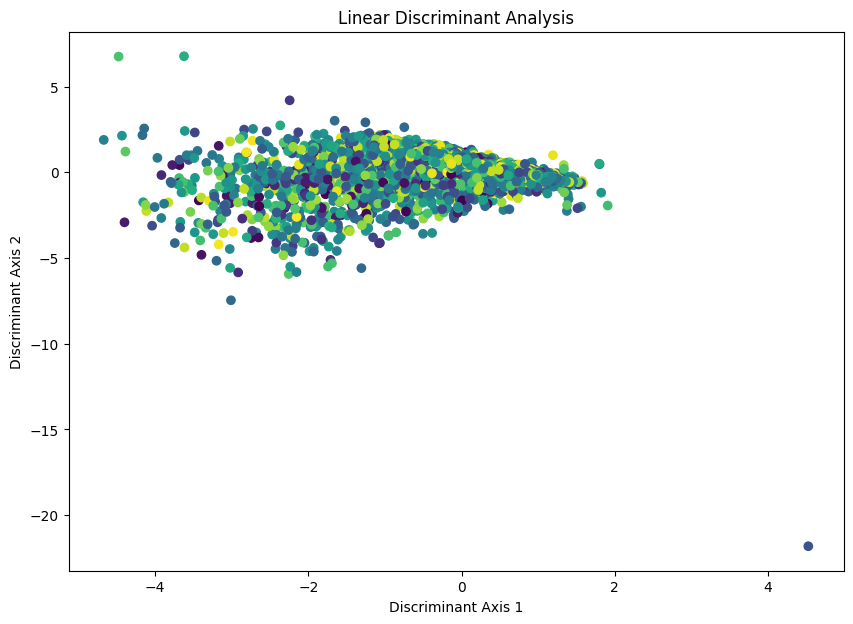

In [ ]:
# Linear Discriminant Analysis (LDA)

# Load the data
df = pd.read_json('/content/stock_data_0.json')

# Handle missing values
df = df.dropna()

# Convert categorical columns to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# Separate features and target
X = df.drop('TYPE', axis=1)  # assuming 'TYPE' is the target
y = df['TYPE']

# Perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# Project data onto the discriminant axis
X_projected = lda.transform(X)

# Plot the data
plt.figure(figsize=(10, 7))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y, cmap='viridis')
plt.xlabel('Discriminant Axis 1')
plt.ylabel('Discriminant Axis 2')
plt.title('Linear Discriminant Analysis')
plt.show()


[[2536.67399852 -328.04777507]
 [2535.91100451 -309.28268805]
 [2537.62869058  -36.26548763]
 ...
 [2470.66665156 -328.9279971 ]
 [2472.35227383   18.42889594]
 [2465.72793694  -25.49471059]]


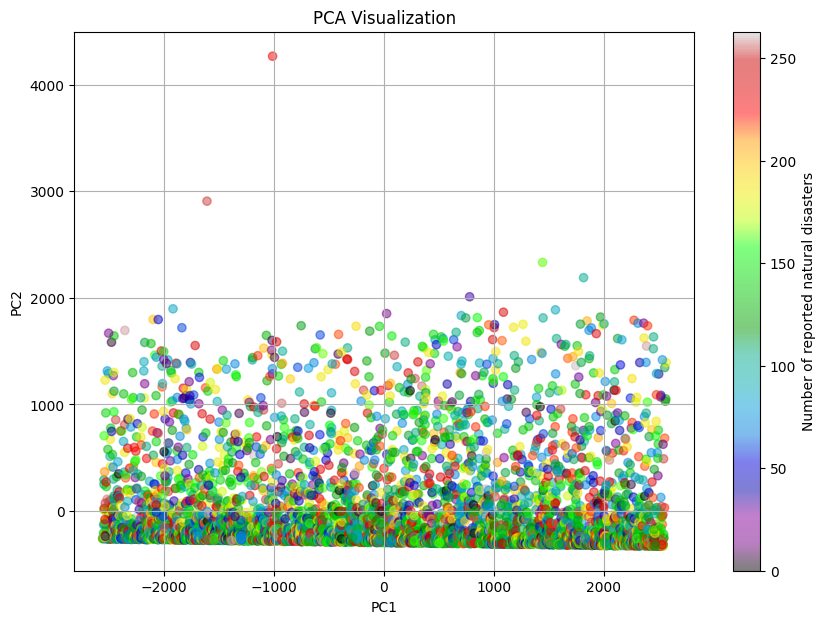

In [ ]:
"""------------------------------------------------------------------Principal Component Analysis (PCA)----------------------------------------------------------------------------"""
# Load the data
df = pd.read_json('/content/stock_data_0.json')

# Handle missing values
df = df.dropna()

# Convert categorical columns to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# Separate features and target
X = df.drop('TYPE', axis=1)  # assuming 'TYPE' is the target
y = df['TYPE']

# Perform PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print(f"{X_reduced}")


# Plot the data
plt.figure(figsize=(10, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='nipy_spectral', alpha=0.5)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Number of reported natural disasters')
plt.grid(True)
plt.show()




/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[[ 0.02421539 -0.00975972]
 [ 0.02420064 -0.00918358]
 [ 0.02410768 -0.00079961]
 ...
 [ 0.02358905 -0.00979492]
 [ 0.02346603  0.00087186]
 [ 0.02342071 -0.00047776]]


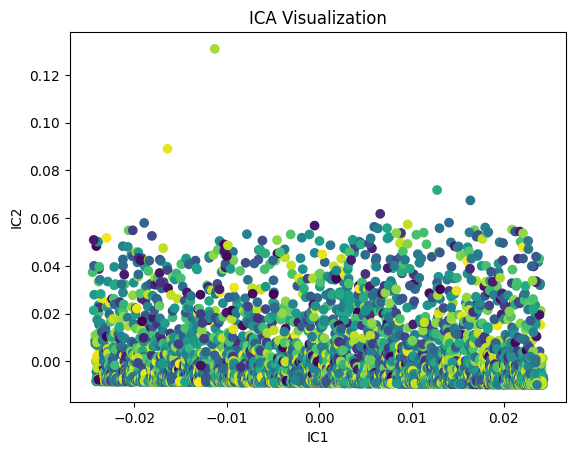

In [ ]:
"""------------------------------------------------------------------Independent Component Analysis----------------------------------------------------------------------------"""


# Load the data
df = pd.read_json('/content/stock_data_0.json')

# Handle missing values
df = df.dropna()

# Convert categorical columns to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# Separate features and target
X = df.drop('TYPE', axis=1)  # assuming 'TYPE' is the target
y = df['TYPE']

# Perform ICA

ica = FastICA(n_components=2)
X_reduced = ica.fit_transform(X)

print(f"{X_reduced}")

# Visualize the results
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis')
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.title('ICA Visualization')
plt.show()


Factor loadings:
          NAME        COST  STRENGTH  WEAKNESS  OPPORTUNITIES   THREATS  \
0  1472.874133   -9.123358 -0.455731  0.106494       0.029211  0.000600   
1     0.063998  204.554661 -0.725488 -1.434653      -0.774457  0.019868   
2    -0.000412  -10.301485 -1.433261  0.243816       0.179330 -0.013778   

        P_LOW      P_HIGH  YEARLY_LOW  YEARLY_HIGH  
0   -8.558658   -8.961539   -4.893597    -8.225392  
1  208.014758  214.740166  112.510828   246.457216  
2   -7.297682   -7.639994   21.362077    91.992385  


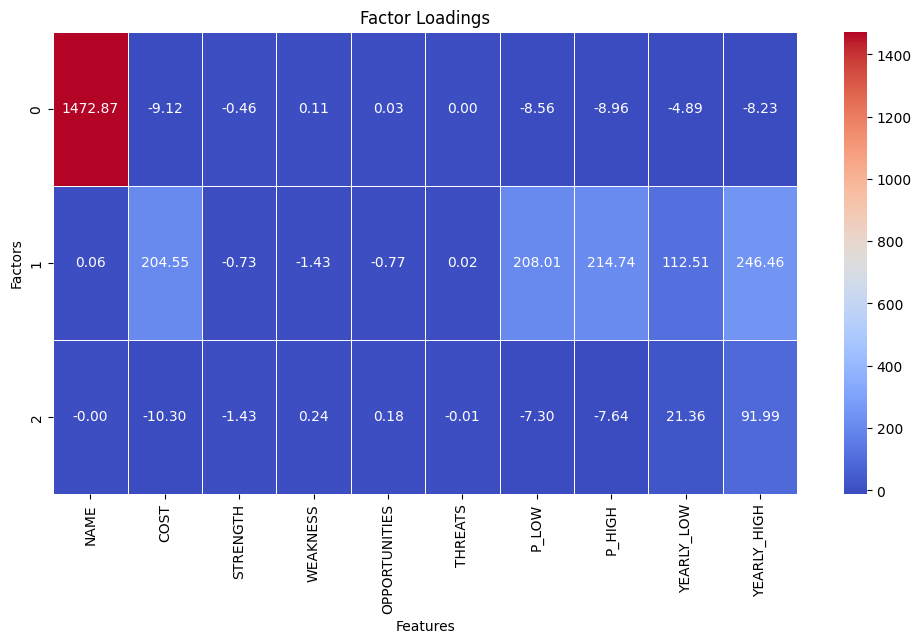

In [ ]:
"""------------------------------------------------Implementation of Factor Analysis--------------------------------------------------------"""

# Perform Factor Analysis
fa = FactorAnalysis(n_components=3)
fa.fit(X)

# Get the factor loadings
loadings = fa.components_

# Create a DataFrame to view the loadings
loadings_df = pd.DataFrame(loadings, columns=X.columns)

print("Factor loadings:")
print(loadings_df)

# Plot the factor loadings
plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Factor Loadings')
plt.xlabel('Features')
plt.ylabel('Factors')
plt.show()

[[14.234284 54.556522]
 [14.290757 53.90052 ]
 [24.224575 40.793034]
 ...
 [17.71292  56.315514]
 [25.31451  40.222313]
 [25.211943 40.92103 ]]


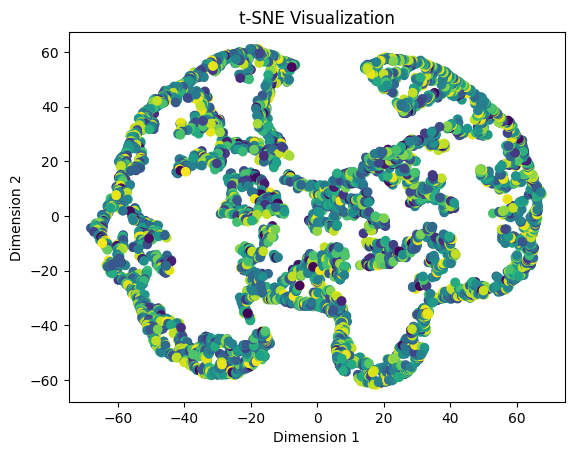

In [ ]:
"""----------------------------------------t-Distributed Stochastic Neighbor Embedding(t-SNE)-----------------------------------------------"""
# Load the data
df = pd.read_json('/content/stock_data_0.json')

# Handle missing values
df = df.dropna()

# Convert categorical columns to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# Separate features and target
X = df.drop('TYPE', axis=1)  # assuming 'TYPE' is the target
y = df['TYPE']

# Perform t-SNE
tsne = TSNE(n_components=2)
X_reduced = tsne.fit_transform(X)

print(f"{X_reduced}")

# Visualize the results
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization')
plt.show()
